In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/Umair/Temp"

/content/drive/MyDrive/Umair/Temp


In [3]:
import zipfile
import os

def unzip_file(source_zip_path, destination_dir):
    # Ensure the destination directory exists
    os.makedirs(destination_dir, exist_ok=True)

    # Unzip the file
    with zipfile.ZipFile(source_zip_path, 'r') as zip_ref:
        zip_ref.extractall(destination_dir)
        print(f"Extracted '{source_zip_path}' to '{destination_dir}'")

# Example usage
source_zip = "/content/drive/MyDrive/Umair/Temp/Images.zip"
destination = "/content/drive/MyDrive/Umair/Temp/DATA"

unzip_file(source_zip, destination)


Extracted '/content/drive/MyDrive/Umair/Temp/Images.zip' to '/content/drive/MyDrive/Umair/Temp/DATA'


In [21]:
source_zip = "/content/drive/MyDrive/Umair/Temp/Airplanes_Annotations.zip"
destination = "/content/drive/MyDrive/Umair/Temp/DATA"

unzip_file(source_zip, destination)

Extracted '/content/drive/MyDrive/Umair/Temp/Airplanes_Annotations.zip' to '/content/drive/MyDrive/Umair/Temp/DATA'


In [5]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [22]:
path = "/content/drive/MyDrive/Umair/Temp/DATA/Images"
annot = "/content/drive/MyDrive/Umair/Temp/DATA/Airplanes_Annotations"

airplane_095.jpg


/tmp/ipython-input-4248337454.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-4248337454.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-4248337454.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-4248337454.py:12: FutureWarning: Series.__getitem__ treating keys a

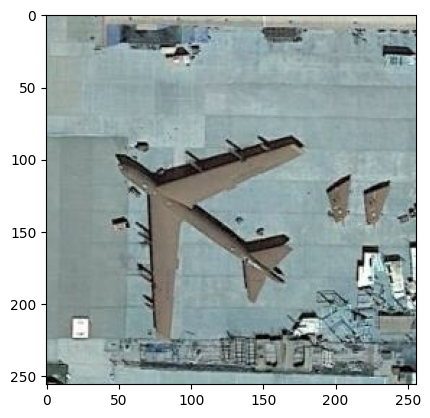

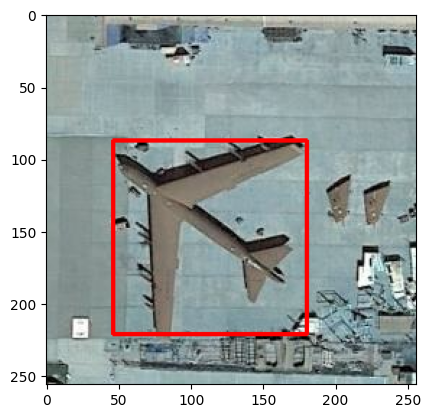

In [25]:
for e,i in enumerate(os.listdir(annot)):
    if e < 10:
        filename = i.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(annot,i))
        plt.imshow(img)
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
        plt.figure()
        plt.imshow(img)
        break

In [26]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

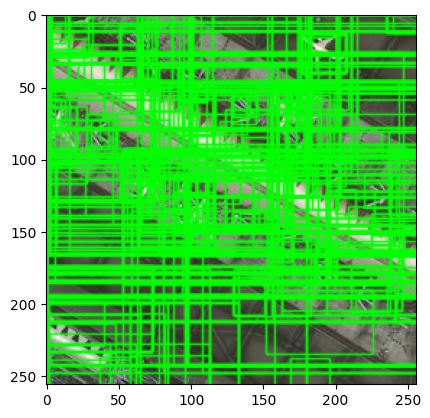

In [31]:
im = cv2.imread(os.path.join(path,"428461.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    # print(x,y,w,h)
    # imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

In [32]:
train_images=[]
train_labels=[]

In [33]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [34]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [35]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 airplane_095.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

1 airplane_094.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

2 airplane_093.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

3 airplane_092.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

4 airplane_091.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

5 airplane_090.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

6 airplane_089.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

7 airplane_088.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

8 airplane_087.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

9 airplane_086.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

10 airplane_085.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
11 airplane_084.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

12 airplane_083.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
13 airplane_082.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

14 airplane_081.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

15 airplane_080.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

16 airplane_079.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

17 airplane_078.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

18 airplane_077.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

19 airplane_076.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

20 airplane_075.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
21 airplane_074.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

22 airplane_073.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

23 airplane_072.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

24 airplane_070.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

25 airplane_067.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

26 airplane_065.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

27 airplane_062.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
28 airplane_059.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

29 airplane_057.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

30 airplane_054.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

31 airplane_051.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

32 airplane_049.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

33 airplane_046.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

34 airplane_043.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

35 airplane_041.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
36 airplane_038.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

37 airplane_035.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

38 airplane_033.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

39 airplane_030.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

40 airplane_027.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

41 airplane_025.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

42 airplane_022.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

43 airplane_019.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

44 airplane_017.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

45 airplane_014.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

46 airplane_011.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

47 airplane_009.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

48 airplane_006.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

49 airplane_003.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

50 airplane_001.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
78 airplane_071.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

79 airplane_069.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

80 airplane_068.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

81 airplane_066.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

82 airplane_064.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

83 airplane_063.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

84 airplane_061.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

85 airplane_060.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

86 airplane_058.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

87 airplane_056.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

88 airplane_055.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

89 airplane_053.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
90 airplane_052.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

91 airplane_050.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

92 airplane_048.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

93 airplane_047.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

94 airplane_045.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
95 airplane_044.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

96 airplane_042.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

97 airplane_040.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

98 airplane_039.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

99 airplane_037.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

100 airplane_036.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

101 airplane_034.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

102 airplane_032.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

103 airplane_031.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

104 airplane_029.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

105 airplane_028.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

106 airplane_026.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

107 airplane_024.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

108 airplane_023.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

109 airplane_021.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

110 airplane_020.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

111 airplane_018.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

112 airplane_016.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

113 airplane_015.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

114 airplane_013.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

115 airplane_012.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
116 airplane_010.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

117 airplane_008.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

118 airplane_007.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
119 airplane_005.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
120 airplane_004.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
121 airplane_002.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

128 airplane_223.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
129 airplane_222.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

130 airplane_221.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

131 airplane_220.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

132 airplane_219.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

133 airplane_218.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

134 airplane_217.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

135 airplane_216.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

136 airplane_215.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

137 airplane_214.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
138 airplane_213.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
139 airplane_212.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

140 airplane_211.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

141 airplane_210.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

142 airplane_209.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

143 airplane_208.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

144 airplane_207.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

145 airplane_206.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

146 airplane_205.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

147 airplane_204.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

148 airplane_203.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

149 airplane_202.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

150 airplane_201.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

151 airplane_200.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

152 airplane_199.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
153 airplane_198.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

154 airplane_197.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

155 airplane_196.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

156 airplane_195.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

157 airplane_194.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

158 airplane_193.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

159 airplane_192.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

160 airplane_191.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

161 airplane_190.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
162 airplane_189.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

163 airplane_188.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

164 airplane_187.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

165 airplane_186.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

166 airplane_185.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

167 airplane_184.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

168 airplane_183.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

169 airplane_182.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

170 airplane_181.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

171 airplane_180.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

172 airplane_179.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

173 airplane_178.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

174 airplane_177.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

175 airplane_176.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

176 airplane_175.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

177 airplane_174.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

178 airplane_173.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

179 airplane_172.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

180 airplane_171.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

181 airplane_170.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

182 airplane_169.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

183 airplane_168.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

184 airplane_167.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

185 airplane_166.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

186 airplane_165.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

187 airplane_164.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

188 airplane_163.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

189 airplane_162.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

190 airplane_161.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

191 airplane_160.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

192 airplane_159.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

193 airplane_158.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

194 airplane_157.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

195 airplane_156.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

196 airplane_155.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

197 airplane_154.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

198 airplane_153.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

199 airplane_152.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

200 airplane_151.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
201 airplane_150.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

202 airplane_149.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

203 airplane_148.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

204 airplane_147.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

205 airplane_146.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

206 airplane_145.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

207 airplane_144.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

208 airplane_143.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

209 airplane_142.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

210 airplane_141.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

211 airplane_140.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

212 airplane_139.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

213 airplane_138.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

214 airplane_137.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
215 airplane_136.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
216 airplane_135.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

217 airplane_134.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

218 airplane_133.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

219 airplane_132.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

220 airplane_131.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

221 airplane_130.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

222 airplane_129.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

223 airplane_128.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

224 airplane_127.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

225 airplane_126.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
226 airplane_125.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

227 airplane_124.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

228 airplane_123.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
229 airplane_122.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

230 airplane_121.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
231 airplane_120.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
232 airplane_119.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
233 airplane_118.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

234 airplane_117.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

235 airplane_116.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

236 airplane_115.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

237 airplane_114.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

238 airplane_113.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

239 airplane_112.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
240 airplane_111.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

241 airplane_110.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

242 airplane_109.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

243 airplane_108.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
244 airplane_107.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

245 airplane_106.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

246 airplane_105.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

247 airplane_104.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

248 airplane_103.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

249 airplane_102.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

250 airplane_101.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

251 airplane_100.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

252 airplane_099.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

253 airplane_098.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

254 airplane_097.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
255 airplane_096.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
256 airplane_351.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

257 airplane_350.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

258 airplane_349.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

259 airplane_348.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

260 airplane_347.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
261 airplane_346.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

262 airplane_345.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

263 airplane_344.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

264 airplane_343.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
265 airplane_342.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

266 airplane_341.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

267 airplane_340.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

268 airplane_339.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

269 airplane_338.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
270 airplane_337.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

271 airplane_336.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

272 airplane_335.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

273 airplane_334.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

274 airplane_333.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

275 airplane_332.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
276 airplane_331.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

277 airplane_330.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

278 airplane_329.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

279 airplane_328.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
280 airplane_327.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

281 airplane_326.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
282 airplane_325.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

283 airplane_324.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

284 airplane_323.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

285 airplane_322.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

286 airplane_321.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

287 airplane_320.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

288 airplane_319.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

289 airplane_318.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

290 airplane_317.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

291 airplane_316.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

292 airplane_315.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
293 airplane_314.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

294 airplane_313.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

295 airplane_312.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

296 airplane_311.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

297 airplane_310.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

298 airplane_309.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

299 airplane_308.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

300 airplane_307.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

301 airplane_306.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
302 airplane_305.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
303 airplane_304.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

304 airplane_303.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

305 airplane_302.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

306 airplane_301.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
307 airplane_300.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

308 airplane_299.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

309 airplane_298.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

310 airplane_297.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
311 airplane_296.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

312 airplane_295.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

313 airplane_294.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

314 airplane_293.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

315 airplane_292.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

316 airplane_291.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
317 airplane_290.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

318 airplane_289.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
319 airplane_288.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

320 airplane_287.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

321 airplane_286.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

322 airplane_285.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

323 airplane_284.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

324 airplane_283.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

325 airplane_282.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

326 airplane_281.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

327 airplane_280.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

328 airplane_279.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

329 airplane_278.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

330 airplane_277.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

331 airplane_276.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
332 airplane_275.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

333 airplane_274.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

334 airplane_273.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

335 airplane_272.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

336 airplane_271.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

337 airplane_270.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

338 airplane_269.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

339 airplane_268.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

340 airplane_267.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

341 airplane_266.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

342 airplane_265.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

343 airplane_264.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
344 airplane_263.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

345 airplane_262.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

346 airplane_261.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

347 airplane_260.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

348 airplane_259.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

349 airplane_258.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

350 airplane_257.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

351 airplane_256.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

352 airplane_255.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

353 airplane_254.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

354 airplane_253.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

355 airplane_252.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

356 airplane_251.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

357 airplane_250.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

358 airplane_249.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

359 airplane_248.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

360 airplane_247.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

361 airplane_246.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

362 airplane_245.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

363 airplane_244.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

364 airplane_243.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

365 airplane_242.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

366 airplane_241.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

367 airplane_240.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

368 airplane_239.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

369 airplane_238.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

370 airplane_237.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

371 airplane_236.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

372 airplane_235.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

373 airplane_234.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

374 airplane_233.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

375 airplane_232.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

376 airplane_231.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

377 airplane_230.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

378 airplane_229.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

379 airplane_228.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

380 airplane_227.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

381 airplane_226.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

382 airplane_225.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
383 airplane_224.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

384 airplane_479.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

385 airplane_478.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

386 airplane_477.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

387 airplane_476.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

388 airplane_475.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

389 airplane_474.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

390 airplane_473.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

391 airplane_472.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

392 airplane_471.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

393 airplane_470.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

394 airplane_469.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
395 airplane_468.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

396 airplane_467.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

397 airplane_466.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

398 airplane_465.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

399 airplane_464.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

400 airplane_463.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

401 airplane_462.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

402 airplane_461.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

403 airplane_460.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

404 airplane_459.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

405 airplane_458.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

406 airplane_457.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

407 airplane_456.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

408 airplane_455.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

409 airplane_454.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

410 airplane_453.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

411 airplane_452.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
412 airplane_451.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

413 airplane_450.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

414 airplane_449.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

415 airplane_448.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

416 airplane_447.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

417 airplane_446.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

418 airplane_445.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

419 airplane_444.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

420 airplane_443.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

421 airplane_442.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

422 airplane_441.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

423 airplane_440.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

424 airplane_439.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

425 airplane_438.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

426 airplane_437.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

427 airplane_436.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

428 airplane_435.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

429 airplane_434.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
430 airplane_433.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

431 airplane_432.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

432 airplane_431.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

433 airplane_430.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

434 airplane_429.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

435 airplane_428.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

436 airplane_427.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
437 airplane_426.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

438 airplane_425.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

439 airplane_424.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

440 airplane_423.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

441 airplane_422.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

442 airplane_421.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

443 airplane_420.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

444 airplane_419.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
445 airplane_418.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

446 airplane_417.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

447 airplane_416.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

448 airplane_415.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

449 airplane_414.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

450 airplane_413.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

451 airplane_412.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

452 airplane_411.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

453 airplane_410.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

454 airplane_409.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

455 airplane_408.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

456 airplane_407.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

457 airplane_406.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

458 airplane_405.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

459 airplane_404.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

460 airplane_403.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

461 airplane_402.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

462 airplane_401.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

463 airplane_400.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

464 airplane_399.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

465 airplane_398.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

466 airplane_397.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

467 airplane_396.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

468 airplane_395.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

469 airplane_394.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

470 airplane_393.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

471 airplane_392.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

472 airplane_391.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

473 airplane_390.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

474 airplane_389.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

475 airplane_388.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
476 airplane_387.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

477 airplane_386.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

478 airplane_385.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
479 airplane_384.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

480 airplane_383.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
481 airplane_382.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
482 airplane_381.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

483 airplane_380.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

484 airplane_379.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

485 airplane_378.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

486 airplane_377.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
487 airplane_376.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

488 airplane_375.jpg
489 airplane_374.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

490 airplane_373.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
491 airplane_372.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

492 airplane_371.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

493 airplane_370.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

494 airplane_369.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

495 airplane_368.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

496 airplane_367.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

497 airplane_366.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

498 airplane_365.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

499 airplane_364.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

500 airplane_363.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

501 airplane_362.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
502 airplane_361.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

503 airplane_360.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

504 airplane_359.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

505 airplane_358.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

506 airplane_357.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

507 airplane_356.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

508 airplane_355.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

509 airplane_354.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

510 airplane_353.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

511 airplane_352.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

512 airplane_607.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

513 airplane_606.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

514 airplane_605.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

515 airplane_604.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

516 airplane_603.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

517 airplane_602.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

518 airplane_601.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

519 airplane_600.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

520 airplane_599.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

521 airplane_598.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

522 airplane_597.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

523 airplane_596.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
524 airplane_595.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

525 airplane_594.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

526 airplane_593.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
527 airplane_592.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

528 airplane_591.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

529 airplane_590.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
530 airplane_589.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

531 airplane_588.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

532 airplane_587.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

533 airplane_586.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

534 airplane_585.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

535 airplane_584.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

536 airplane_583.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

537 airplane_582.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

538 airplane_581.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

539 airplane_580.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

540 airplane_579.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

541 airplane_578.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

542 airplane_577.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

543 airplane_576.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

544 airplane_575.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

545 airplane_574.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

546 airplane_573.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

547 airplane_572.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

548 airplane_571.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

549 airplane_570.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

550 airplane_569.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

551 airplane_568.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
552 airplane_567.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

553 airplane_566.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

554 airplane_565.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

555 airplane_564.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

556 airplane_563.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

557 airplane_562.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

558 airplane_561.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
559 airplane_560.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

560 airplane_559.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

561 airplane_558.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

562 airplane_557.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

563 airplane_556.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

564 airplane_555.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
565 airplane_554.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

566 airplane_553.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
567 airplane_552.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

568 airplane_551.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
569 airplane_550.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

570 airplane_549.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

571 airplane_548.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

572 airplane_547.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

573 airplane_546.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

574 airplane_545.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

575 airplane_544.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

576 airplane_543.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

577 airplane_542.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

578 airplane_541.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

579 airplane_540.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

580 airplane_539.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

581 airplane_538.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

582 airplane_537.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

583 airplane_536.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

584 airplane_535.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

585 airplane_534.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

586 airplane_533.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

587 airplane_532.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

588 airplane_531.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

589 airplane_530.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

590 airplane_529.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

591 airplane_528.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

592 airplane_527.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

593 airplane_526.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
594 airplane_525.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

595 airplane_524.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

596 airplane_523.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

597 airplane_522.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

598 airplane_521.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

599 airplane_520.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

600 airplane_519.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

601 airplane_518.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

602 airplane_517.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

603 airplane_516.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

604 airplane_515.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

605 airplane_514.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

606 airplane_513.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

607 airplane_512.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

608 airplane_511.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

609 airplane_510.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

610 airplane_509.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

611 airplane_508.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

612 airplane_507.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

613 airplane_506.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

614 airplane_505.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

615 airplane_504.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
616 airplane_503.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

617 airplane_502.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

618 airplane_501.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

619 airplane_500.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

620 airplane_499.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

621 airplane_498.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

622 airplane_497.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
623 airplane_496.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

624 airplane_495.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

625 airplane_494.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

626 airplane_493.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

627 airplane_492.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

628 airplane_491.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

629 airplane_490.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

630 airplane_489.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

631 airplane_488.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

632 airplane_487.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
633 airplane_486.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

634 airplane_485.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

635 airplane_484.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

636 airplane_483.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

637 airplane_482.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

638 airplane_481.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

639 airplane_480.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

640 airplane_700.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

641 airplane_699.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

642 airplane_698.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

643 airplane_697.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

644 airplane_696.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

645 airplane_695.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

646 airplane_694.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

647 airplane_693.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

648 airplane_692.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

649 airplane_691.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

650 airplane_690.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

651 airplane_689.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

652 airplane_688.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

653 airplane_687.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

654 airplane_686.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

655 airplane_685.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

656 airplane_684.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

657 airplane_683.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

658 airplane_682.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

659 airplane_681.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

660 airplane_680.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

661 airplane_679.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

662 airplane_678.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

663 airplane_677.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

664 airplane_676.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

665 airplane_675.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

666 airplane_674.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

667 airplane_673.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

668 airplane_672.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

669 airplane_671.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

670 airplane_670.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

671 airplane_669.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

672 airplane_668.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

673 airplane_667.jpg
674 airplane_666.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

675 airplane_665.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

676 airplane_664.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

677 airplane_663.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

678 airplane_662.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

679 airplane_661.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

680 airplane_660.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

681 airplane_659.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

682 airplane_658.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
683 airplane_657.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

684 airplane_656.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

685 airplane_655.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

686 airplane_654.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

687 airplane_653.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

688 airplane_652.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

689 airplane_651.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

690 airplane_650.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

691 airplane_649.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

692 airplane_648.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

693 airplane_647.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

694 airplane_646.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

695 airplane_645.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
696 airplane_644.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

697 airplane_643.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

698 airplane_642.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

699 airplane_641.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

700 airplane_640.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

701 airplane_639.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

702 airplane_638.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
703 airplane_637.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

704 airplane_636.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

705 airplane_635.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

706 airplane_634.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

707 airplane_633.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

708 airplane_632.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

709 airplane_631.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

710 airplane_630.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

711 airplane_629.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

712 airplane_628.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

713 airplane_627.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

714 airplane_626.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

715 airplane_625.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

716 airplane_624.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
717 airplane_623.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

718 airplane_622.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

719 airplane_621.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
720 airplane_620.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

721 airplane_619.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
722 airplane_618.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

723 airplane_617.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

724 airplane_616.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

inside
725 airplane_615.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

726 airplane_614.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

727 airplane_613.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

728 airplane_612.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

729 airplane_611.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

730 airplane_610.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

731 airplane_609.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

732 airplane_608.jpg


/tmp/ipython-input-526527756.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
/tmp/ipython-input-526527756.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
/tmp/ipython-input-526527756.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2])
/tmp/ipython-input-526527756.py:13: FutureWarning: Series.__getitem__ treating keys as p

In [36]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [37]:
X_new.shape

(30229, 224, 224, 3)

In [39]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16

In [40]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

<InputLayer name=input_layer, built=True>
<Conv2D name=block1_conv1, built=True>
<Conv2D name=block1_conv2, built=True>
<MaxPooling2D name=block1_pool, built=True>
<Conv2D name=block2_conv1, built=True>
<Conv2D name=block2_conv2, built=True>
<MaxPooling2D name=block2_pool, built=True>
<Conv2D name=block3_conv1, built=True>
<Conv2D name=block3_conv2, built=True>
<Conv2D name=block3_conv3, built=True>
<MaxPooling2D name=block3_pool, built=True>
<Conv2D name=block4_conv1, built=True>
<Conv2D name=block4_conv2, built=True>
<Conv2D name=block4_conv3, built=True>
<MaxPooling2D name=block4_pool, built=True>


In [42]:
X= vggmodel.layers[-2].output

In [43]:
predictions = Dense(2, activation="softmax")(X)

In [47]:
model_final = Model(inputs=vggmodel.input, outputs=predictions)


In [48]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)

In [49]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [50]:
model_final.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 126,633,474 (483.07 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [52]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [53]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [54]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [55]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(27206, 224, 224, 3) (3023, 224, 224, 3) (27206, 2) (3023, 2)


In [56]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [60]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    "ieeercnn_vgg16_1.h5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto'
)

early = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=100,
    verbose=1,
    mode='auto'
)


In [62]:
hist = model_final.fit(
    traindata,
    steps_per_epoch=10,
    epochs=1000,
    validation_data=testdata,
    validation_steps=2,
    callbacks=[checkpoint, early]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.6038 - loss: 2.0613
Epoch 1: val_loss improved from inf to 0.51741, saving model to ieeercnn_vgg16_1.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6097 - loss: 2.0108 - val_accuracy: 0.7500 - val_loss: 0.5174
Epoch 2/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.7722 - loss: 0.4557
Epoch 2: val_loss improved from 0.51741 to 0.23056, saving model to ieeercnn_vgg16_1.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7738 - loss: 0.4526 - val_accuracy: 0.9375 - val_loss: 0.2306
Epoch 3/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.8606 - loss: 0.3332
Epoch 3: val_loss improved from 0.23056 to 0.20069, saving model to ieeercnn_vgg16_1.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8597 - loss: 0.3342 - val_accuracy: 0.9375 - val_loss: 0.2007
Epoch 4/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9116 - loss: 0.2252
Epoch 4: val_loss improved from 0.20069 to 0.18582, saving model to ieeercnn_vgg16_1.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 917ms/step - accuracy: 0.9088 - loss: 0.2358 - val_accuracy: 0.9219 - val_loss: 0.1858
Epoch 5/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8942 - loss: 0.2429
Epoch 5: val_loss did not improve from 0.18582
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.8930 - loss: 0.2454 - val_accuracy: 0.8438 - val_loss: 0.2881
Epoch 6/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - accuracy: 0.8839 - loss: 0.2606
Epoch 6: val_loss did not improve from 0.18582
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8876 - loss: 0.2552 - val_accuracy: 0.9062 - val_loss: 0.3117
Epoch 7/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9147 - loss: 0.2509
Epoch 7: val_loss improved from 0.18582 to 0.15163, saving model to ieeercnn_vgg16_1.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 956ms/step - accuracy: 0.9134 - loss: 0.2516 - val_accuracy: 0.9531 - val_loss: 0.1516
Epoch 8/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9136 - loss: 0.1844
Epoch 8: val_loss did not improve from 0.15163
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - accuracy: 0.9138 - loss: 0.1842 - val_accuracy: 0.8594 - val_loss: 0.5932
Epoch 9/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9068 - loss: 0.2076
Epoch 9: val_loss improved from 0.15163 to 0.14218, saving model to ieeercnn_vgg16_1.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9076 - loss: 0.2078 - val_accuracy: 0.9688 - val_loss: 0.1422
Epoch 10/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9307 - loss: 0.2187
Epoch 10: val_loss did not improve from 0.14218
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.9305 - loss: 0.2178 - val_accuracy: 0.8281 - val_loss: 0.5333
Epoch 11/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8991 - loss: 0.2478
Epoch 11: val_loss did not improve from 0.14218
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.8986 - loss: 0.2476 - val_accuracy: 0.9219 - val_loss: 0.2673
Epoch 12/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9307 - loss: 0.1669
Epoch 12: val_loss improved from 0.14218 to 0.12240, saving model to ieeercnn_vgg16_1.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9311 - loss: 0.1670 - val_accuracy: 0.9688 - val_loss: 0.1224
Epoch 13/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8828 - loss: 0.3930
Epoch 13: val_loss did not improve from 0.12240
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.8806 - loss: 0.3938 - val_accuracy: 0.8594 - val_loss: 0.3461
Epoch 14/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8103 - loss: 0.4170
Epoch 14: val_loss did not improve from 0.12240
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - accuracy: 0.8139 - loss: 0.4107 - val_accuracy: 0.9219 - val_loss: 0.2104
Epoch 15/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9172 - loss: 0.2377
Epoch 15: val_loss did not improve from 0.12240
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.9168 - loss: 0.2364 - val_accuracy: 0.9062 - val_loss: 0.3658
Epoch 16/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8806 - loss: 0.2304
Epoch 16: val_loss did not improve

10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9329 - loss: 0.2052 - val_accuracy: 1.0000 - val_loss: 0.0820
Epoch 20/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9236 - loss: 0.1995
Epoch 20: val_loss did not improve from 0.08198
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 0.9221 - loss: 0.2016 - val_accuracy: 0.8906 - val_loss: 0.3013
Epoch 21/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9530 - loss: 0.1593
Epoch 21: val_loss did not improve from 0.08198
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.9530 - loss: 0.1616 - val_accuracy: 0.9062 - val_loss: 0.2270
Epoch 22/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9261 - loss: 0.1864
Epoch 22: val_loss did not improve from 0.08198
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 0.9268 - loss: 0.1861 - val_accuracy: 0.9531 - val_loss: 0.1122
Epoch 23/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9628 - loss: 0.1236
Epoch 23: val_loss did not improve

10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9462 - loss: 0.1324 - val_accuracy: 1.0000 - val_loss: 0.0348
Epoch 46/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9321 - loss: 0.2264
Epoch 46: val_loss did not improve from 0.03484
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 0.9326 - loss: 0.2237 - val_accuracy: 0.9531 - val_loss: 0.1214
Epoch 47/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9649 - loss: 0.1273
Epoch 47: val_loss did not improve from 0.03484
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.9641 - loss: 0.1278 - val_accuracy: 0.9531 - val_loss: 0.1369
Epoch 48/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9471 - loss: 0.1072
Epoch 48: val_loss did not improve from 0.03484
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.9476 - loss: 0.1096 - val_accuracy: 0.9219 - val_loss: 0.1934
Epoch 49/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9651 - loss: 0.1024
Epoch 49: val_loss did not improve

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 86: val_loss did not improve from 0.03484
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9062 - loss: 0.2792 - val_accuracy: 0.9688 - val_loss: 0.1409
Epoch 87/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.9461 - loss: 0.1937
Epoch 87: val_loss did not improve from 0.03484
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 378ms/step - accuracy: 0.9467 - loss: 0.1904 - val_accuracy: 0.9531 - val_loss: 0.1437
Epoch 88/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9479 - loss: 0.1411
Epoch 88: val_loss did not improve from 0.03484
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 355ms/step - accuracy: 0.9470 - loss: 0.1430 - val_accuracy: 0.9844 - val_loss: 0.1150
Epoch 89/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.9491 - loss: 0.1566
Epoch 89: val_loss did not improve from 0.03484
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 300ms/step - accuracy: 0.9485 - loss: 0.1585 - val_accuracy: 0.9219 - val_loss: 0.1507
Epoch 90/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9289

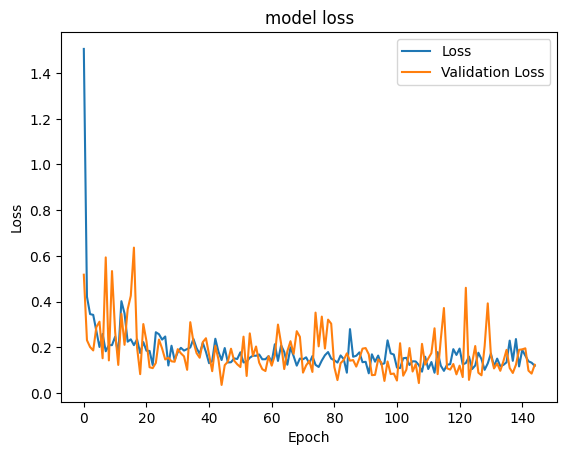

<Figure size 640x480 with 0 Axes>

In [63]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
not plane


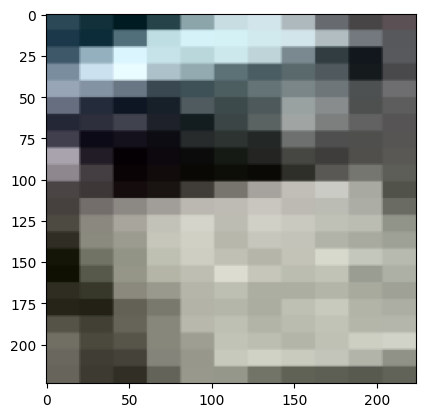

In [65]:
im = X_test[1600]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("plane")
else:
    print("not plane")

In [ ]:
z=0
for e,i in enumerate(os.listdir(path)):
    if i.startswith("4"):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.65:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)